In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython.display import clear_output

In [2]:
from MazeEnvironment import MazeEnvironment

In [3]:
def create_model(width, height, num_actions):
  input_shape = (width * 10, height * 10, 3)

  input_layer = layers.Input(shape=input_shape, name='input_layer')

  x = layers.Conv2D(8, 3, padding='same', activation='relu', name='conv_1_1')(input_layer)
  x = layers.Conv2D(8, 3, padding='same', activation='relu', name='conv_1_2')(x)
  x = layers.MaxPooling2D(4, name='max_pool_1')(x)
  x = layers.BatchNormalization(name='bn_1')(x)

  x = layers.Conv2D(16, 3, padding='same', activation='relu', name='conv_2_1')(x)
  x = layers.Conv2D(16, 3, padding='same', activation='relu', name='conv_2_2')(x)
  x = layers.MaxPooling2D(4, name='max_pool_2')(x)
  x = layers.BatchNormalization(name='bn_2')(x)

  x = layers.Flatten(name='flatten')(x)
  common = layers.Dense(128, name='fc_1')(x)

  action = layers.Dense(num_actions, activation='softmax', name='actor_output')(common)
  critic = layers.Dense(1, name='critic_output')(common)

  model = keras.Model(inputs=input_layer, outputs=[action, critic], name='policy')

  return model

In [4]:
WIDTH = 5
HEIGHT = 5
env = MazeEnvironment(WIDTH, HEIGHT)
state = env.reset()

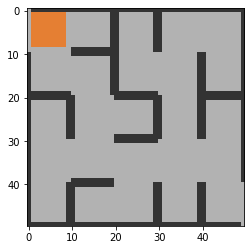

In [5]:
plt.imshow(env.state)
plt.show()

In [6]:
model = create_model(WIDTH, HEIGHT, 4)

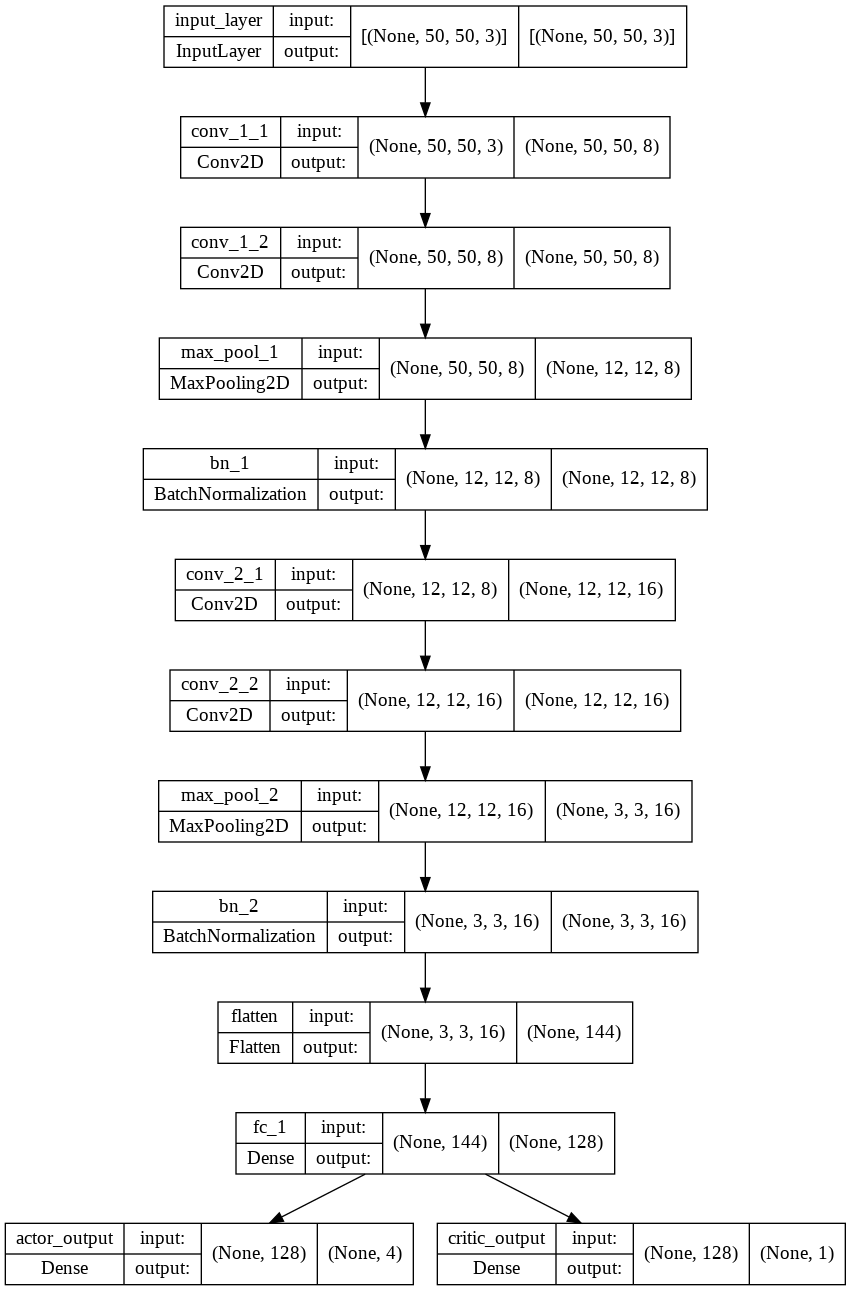

In [7]:
keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "policy"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv_1_1 (Conv2D)              (None, 50, 50, 8)    224         ['input_layer[0][0]']            
                                                                                                  
 conv_1_2 (Conv2D)              (None, 50, 50, 8)    584         ['conv_1_1[0][0]']               
                                                                                                  
 max_pool_1 (MaxPooling2D)      (None, 12, 12, 8)    0           ['conv_1_2[0][0]']               
                                                                                             

In [9]:
def run_episode(env, model, max_steps, num_actions, action_history, critic_value_history, rewards_history):
  env.reset()
  state = env.state

  episode_reward = 0
  for _ in range(max_steps):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    state /= 255.

    action_probs, critic_value = model(state)
    critic_value_history.append(critic_value[0, 0])

    action = np.random.choice(num_actions, p=np.squeeze(action_probs))
    action_history.append(tf.math.log(action_probs[0, action]))
    reward, state, done, _ = env.step(action)

    rewards_history.append(reward)
    episode_reward += reward

    if done:
      break

  return episode_reward

In [10]:
def get_retunrs(gamma, action_probs_history, critic_value_history, rewards_history):
  eps = np.finfo(np.float32).eps.item()

  returns = []
  discounted_sum = 0

  for r in reversed(rewards_history):
    discounted_sum = r + gamma * discounted_sum
    returns.insert(0, discounted_sum)

  returns = np.array(returns)
  returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
  returns = returns.tolist()

  return returns

In [11]:
def compute_loss(action_probs_history, critic_value_history, returns):
  loss = keras.losses.MeanAbsoluteError()

  actor_losses = []
  critic_losses = []

  for log_prob, value, ret in zip(action_probs_history, critic_value_history, returns):
    diff = ret - value

    actor_losses.append(-log_prob * diff) 

    critic_losses.append(
        loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
    )

    loss_value = sum(actor_losses) + sum(critic_losses)
    return loss_value

In [12]:
def train(env, model, num_actions, max_steps, gamma, episodes):
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  avg = 0
  for i in tqdm(range(1, episodes + 1)):
    with tf.GradientTape() as tape:
      critic_value_history = []
      rewards_history = []
      action_history = []

      episode_reward = run_episode(env, model, max_steps, num_actions, action_history, critic_value_history, rewards_history)
      returns = get_retunrs(gamma, action_history, critic_value_history, rewards_history)
      avg += episode_reward 

      loss_value = compute_loss(action_history, critic_value_history, returns)

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if i % 10 == 0:
      avg /= 10
      print(f'Episode reward: {avg}, loss: {loss_value}')
      avg = 0

In [13]:
train(env, model, 4, 100, 0.99, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode reward: -58.0, loss: -0.5710618495941162
Episode reward: -46.1, loss: -0.5871440172195435
Episode reward: -76.2, loss: -0.583405613899231
Episode reward: -70.7, loss: -0.5594666004180908
Episode reward: -85.9, loss: -0.5914909839630127
Episode reward: -62.4, loss: -0.6021300554275513
Episode reward: -56.8, loss: -0.5782699584960938
Episode reward: -74.5, loss: -0.6351485252380371
Episode reward: -45.1, loss: -0.614133358001709
Episode reward: -100.0, loss: -0.6301306486129761
Episode reward: -87.3, loss: -0.7019878625869751
Episode reward: -74.2, loss: -0.7113776206970215
Episode reward: -72.9, loss: -0.8561282157897949
Episode reward: -89.3, loss: -0.8038990497589111
Episode reward: -87.1, loss: -0.8000552654266357
Episode reward: -85.4, loss: -1.03049635887146
Episode reward: -56.5, loss: -1.0300662517547607
Episode reward: -50.8, loss: -0.3264811038970947
Episode reward: -75.7, loss: 0.11176180839538574
Episode reward: -56.1, loss: 0.3916497230529785
Episode reward: -73.6, l

In [14]:
def plot_episode(env, model, max_steps, num_actions):
  env.reset()
  state = env.state

  episode_reward = 0
  for i in range(max_steps):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    state /= 255.
    
    action_probs, critic_value = model(state)
    print(action_probs)
    action = np.random.choice(num_actions, p=np.squeeze(action_probs))
    reward, state, done, _ = env.step(action)
    print(action)
    episode_reward += reward

    plt.imshow(state)
    plt.savefig('image_at_epoch_{:04d}.png'.format(i))
    plt.show()
    if done:
      break

  return episode_reward

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
2


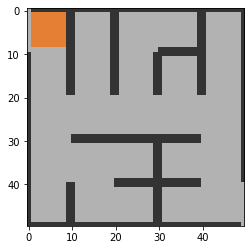

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
3


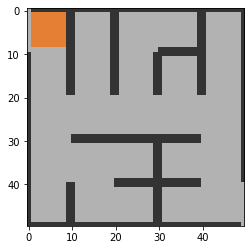

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
3


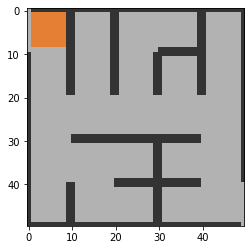

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
2


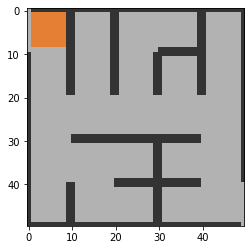

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
0


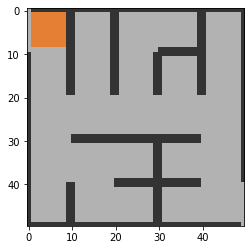

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
2


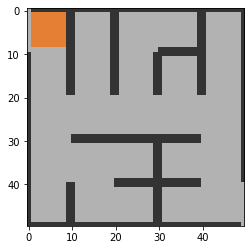

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
3


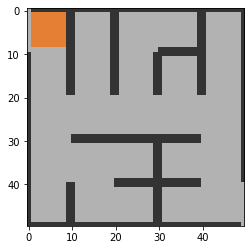

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
2


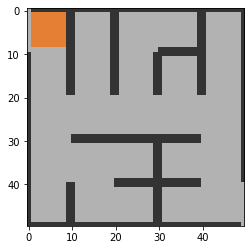

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
2


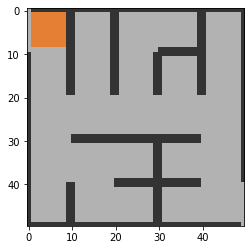

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
3


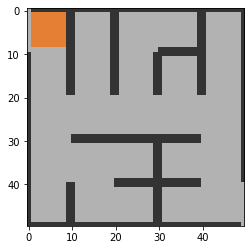

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
2


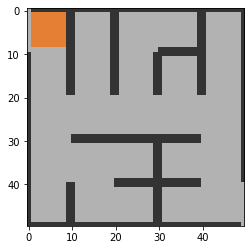

tf.Tensor([[0.11519553 0.13380058 0.6266711  0.12433278]], shape=(1, 4), dtype=float32)
1


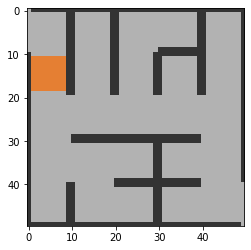

tf.Tensor([[0.11519004 0.13380449 0.62667114 0.12433435]], shape=(1, 4), dtype=float32)
2


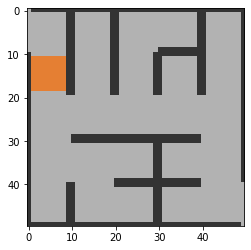

tf.Tensor([[0.11519004 0.13380449 0.62667114 0.12433435]], shape=(1, 4), dtype=float32)
1


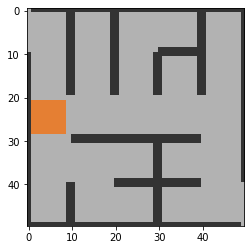

tf.Tensor([[0.1151946  0.13380526 0.6266692  0.12433092]], shape=(1, 4), dtype=float32)
2


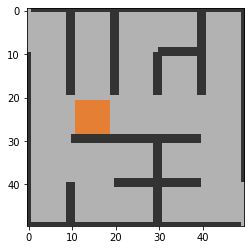

tf.Tensor([[0.11519462 0.13381857 0.6266676  0.12431916]], shape=(1, 4), dtype=float32)
0


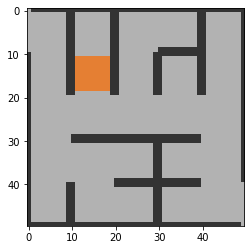

tf.Tensor([[0.11519264 0.13381712 0.6266488  0.12434147]], shape=(1, 4), dtype=float32)
2


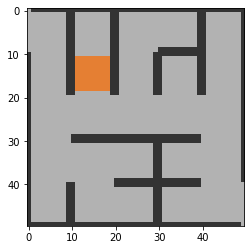

tf.Tensor([[0.11519264 0.13381712 0.6266488  0.12434147]], shape=(1, 4), dtype=float32)
1


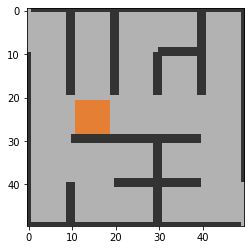

tf.Tensor([[0.11519462 0.13381857 0.6266676  0.12431916]], shape=(1, 4), dtype=float32)
0


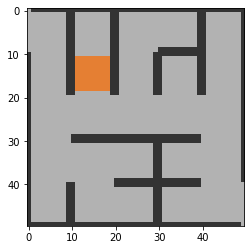

tf.Tensor([[0.11519264 0.13381712 0.6266488  0.12434147]], shape=(1, 4), dtype=float32)
2


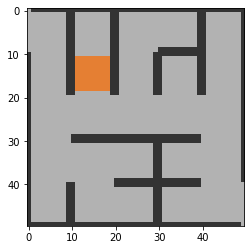

tf.Tensor([[0.11519264 0.13381712 0.6266488  0.12434147]], shape=(1, 4), dtype=float32)
2


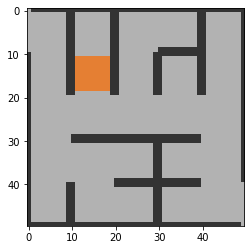

tf.Tensor([[0.11519264 0.13381712 0.6266488  0.12434147]], shape=(1, 4), dtype=float32)
0


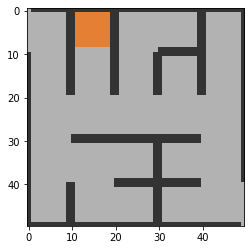

tf.Tensor([[0.11520462 0.13379668 0.6266427  0.12435596]], shape=(1, 4), dtype=float32)
1


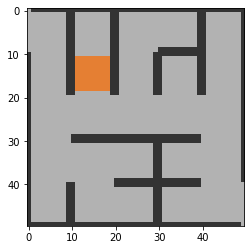

tf.Tensor([[0.11519264 0.13381712 0.6266488  0.12434147]], shape=(1, 4), dtype=float32)
1


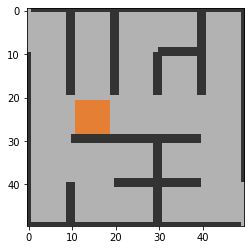

tf.Tensor([[0.11519462 0.13381857 0.6266676  0.12431916]], shape=(1, 4), dtype=float32)
3


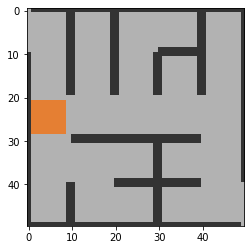

tf.Tensor([[0.1151946  0.13380526 0.6266692  0.12433092]], shape=(1, 4), dtype=float32)
2


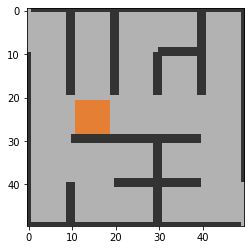

tf.Tensor([[0.11519462 0.13381857 0.6266676  0.12431916]], shape=(1, 4), dtype=float32)
2


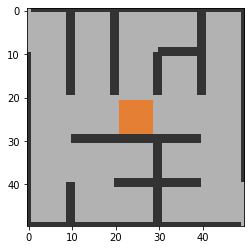

tf.Tensor([[0.11519566 0.13381185 0.62665963 0.12433283]], shape=(1, 4), dtype=float32)
2


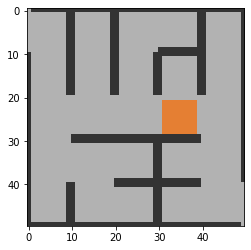

tf.Tensor([[0.11519268 0.13378963 0.62668186 0.12433583]], shape=(1, 4), dtype=float32)
2


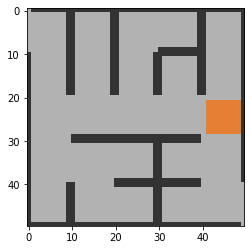

tf.Tensor([[0.11519904 0.13379456 0.6266787  0.12432778]], shape=(1, 4), dtype=float32)
3


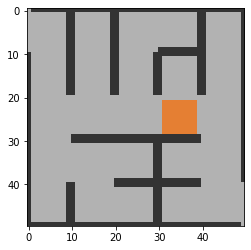

tf.Tensor([[0.11519268 0.13378963 0.62668186 0.12433583]], shape=(1, 4), dtype=float32)
0


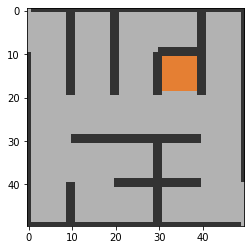

tf.Tensor([[0.11519146 0.13382106 0.62663615 0.12435138]], shape=(1, 4), dtype=float32)
3


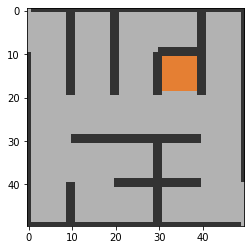

tf.Tensor([[0.11519146 0.13382106 0.62663615 0.12435138]], shape=(1, 4), dtype=float32)
2


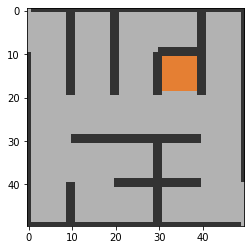

tf.Tensor([[0.11519146 0.13382106 0.62663615 0.12435138]], shape=(1, 4), dtype=float32)
2


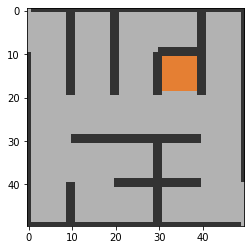

tf.Tensor([[0.11519146 0.13382106 0.62663615 0.12435138]], shape=(1, 4), dtype=float32)
0


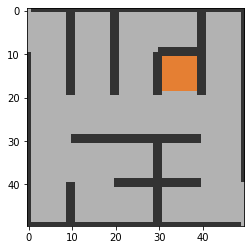

tf.Tensor([[0.11519146 0.13382106 0.62663615 0.12435138]], shape=(1, 4), dtype=float32)
2


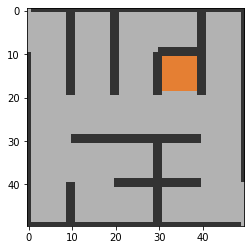

tf.Tensor([[0.11519146 0.13382106 0.62663615 0.12435138]], shape=(1, 4), dtype=float32)
1


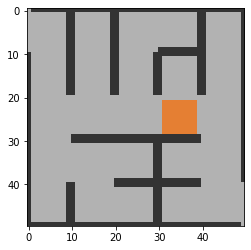

tf.Tensor([[0.11519268 0.13378963 0.62668186 0.12433583]], shape=(1, 4), dtype=float32)
2


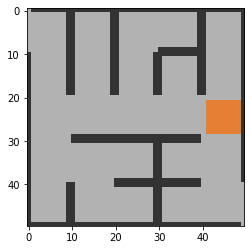

tf.Tensor([[0.11519904 0.13379456 0.6266787  0.12432778]], shape=(1, 4), dtype=float32)
2


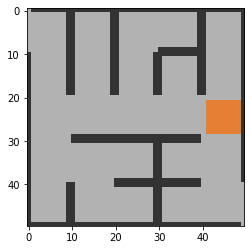

tf.Tensor([[0.11519904 0.13379456 0.6266787  0.12432778]], shape=(1, 4), dtype=float32)
2


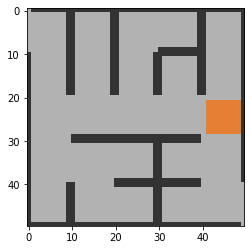

tf.Tensor([[0.11519904 0.13379456 0.6266787  0.12432778]], shape=(1, 4), dtype=float32)
2


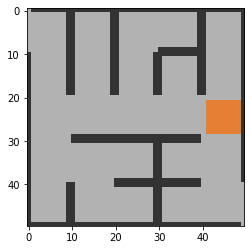

tf.Tensor([[0.11519904 0.13379456 0.6266787  0.12432778]], shape=(1, 4), dtype=float32)
2


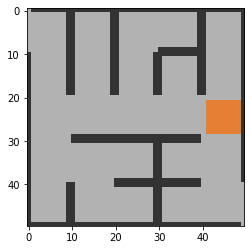

tf.Tensor([[0.11519904 0.13379456 0.6266787  0.12432778]], shape=(1, 4), dtype=float32)
0


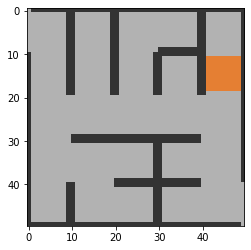

tf.Tensor([[0.11519579 0.13379198 0.6266816  0.12433059]], shape=(1, 4), dtype=float32)
2


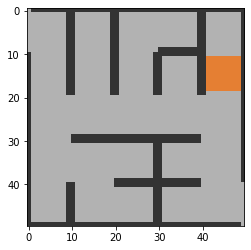

tf.Tensor([[0.11519579 0.13379198 0.6266816  0.12433059]], shape=(1, 4), dtype=float32)
2


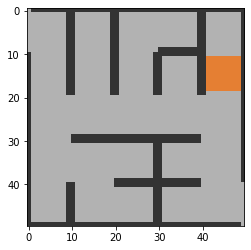

tf.Tensor([[0.11519579 0.13379198 0.6266816  0.12433059]], shape=(1, 4), dtype=float32)
2


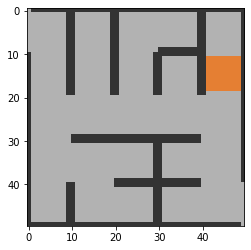

tf.Tensor([[0.11519579 0.13379198 0.6266816  0.12433059]], shape=(1, 4), dtype=float32)
2


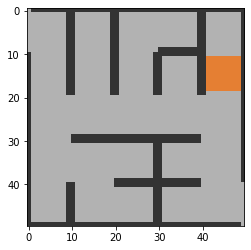

tf.Tensor([[0.11519579 0.13379198 0.6266816  0.12433059]], shape=(1, 4), dtype=float32)
1


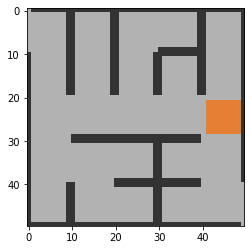

tf.Tensor([[0.11519904 0.13379456 0.6266787  0.12432778]], shape=(1, 4), dtype=float32)
1


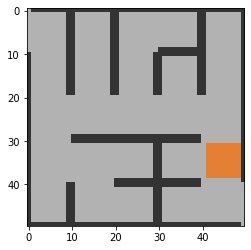

tf.Tensor([[0.11519223 0.13378873 0.6266914  0.12432765]], shape=(1, 4), dtype=float32)
2


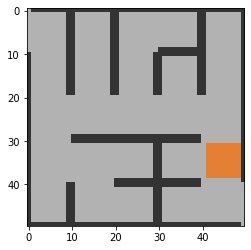

tf.Tensor([[0.11519223 0.13378873 0.6266914  0.12432765]], shape=(1, 4), dtype=float32)
1


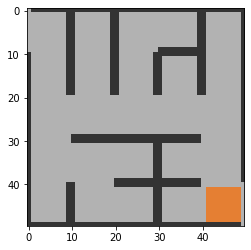

50

In [24]:
plot_episode(env, model, 100, 4)

In [25]:
!pip install -q imageio

In [26]:
import imageio
import glob

In [27]:
anim_file = 'policy.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [28]:
model.save('policy.h5')